## **The Functional API**

### **Introduction**
###### **The ***Keras Functionl API*** is a way to create models that are more flexible than the Sequential API. The Functional API can handle models with non-linear topology, shared layers, and multiple inputs or outputs.**

###### **The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build *graps of layers*.**

###### **Consider the following model:**
```
(input: 784-dimensional vectors)
        !
[Dense (64 units, relu activation)]
        !
[Dense (64 units, relu activation)]
        !
[Dense (10 units, softmax activation)]
        !
(output: logits of a probability distribution over 10 classes)
```

###### **This is a basic graph with three layers. To build this model using the functional API, start by creating an input node:**

**Setup Libraries**

In [1]:
# Setup Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Input Node**

In [3]:
inputs = keras.Input(shape=(784,))
# If, for example we have an image input with a shape of (32,32,3), we would use
img_inputs = keras.Input(shape=(32,32,3))
# We can check out the shape and data type
print("Input Shape:", inputs.shape)
print("Input Datatype:", inputs.dtype)

Input Shape: (None, 784)
Input Datatype: <dtype: 'float32'>


**Create Model**
###### **We can create a new node in the graph of layers by calling a layer on this input object: The "layer call" action is like drawing an arrow from "inputs" to the layer we created.**

In [4]:
dense = layers.Dense(64, activation='relu')
x = dense(inputs)   # Here, we are passing the inputs to the "dense" layer, and got "x" as the output.

###### **Let's add a few more layers to the graph of layers:**

In [5]:
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

###### **Now, we can create a `model` by specifying its inputs and outputs in the graph of layers:**

In [6]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
# Let's check out the model summary
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


###### **We can also plot the model as graph with input and output shapes**

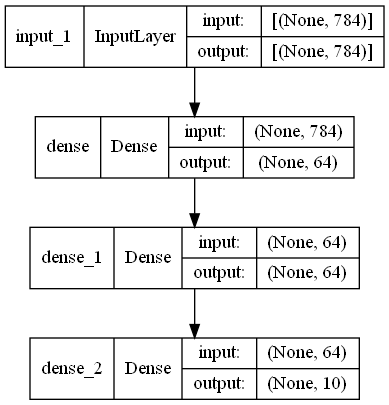

In [7]:
keras.utils.plot_model(model, "mnist_model_info.png", show_shapes=True)

### **Training Evaluation and Inference**
###### **Training, Evaluation and Inference work exactly in the same way for models built using functional api as for `sequential` models. The `model` class offers a built-in training loop(the `fit()` method) and a built-in evaluation loop(the `evaluate()` method). We can easily [customize these loops](https://keras.io/guides/customizing_what_happens_in_fit/).**
###### **Let's load the MNIST image data, reshape it inro vectors, fit the model on the data and then evaluate the model on the test data:**

In [8]:
# Load the data and split then into training and testing
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Reshape the data (Normalization)
x_train = x_train.reshape(60000, 784).astype("float32")/255
x_test = x_test.reshape(10000, 784).astype("float32")/255

# Compile the model
model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = keras.optimizers.RMSprop(),
        metrics = ["accuracy"]
)

# Fit the model to data
history = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, validation_split=0.2)

# Evaluate the model on test data
test_scores = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.3523 - accuracy: 0.9019 - val_loss: 0.2007 - val_accuracy: 0.9402
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1608 - accuracy: 0.9526
Test Loss: 0.16075868904590607
Test Accuracy: 0.9526000022888184


### **Save and Serialize**
###### **The standard way to save a model is to call `model.save()` to save the entire model as a single file. We can later create the same model from this file even if the model is no longer available.<br>This saved files includes- model architecture, model weight values(that are learned during training), model training config, optimizers and its state.**

In [9]:
# Save the model
model.save("mnist_model")

INFO:tensorflow:Assets written to: mnist_model\assets


In [10]:
# Delete the model
#del model

In [13]:
# Recreate the same model from the file:
model = keras.models.load_model("mnist_model")
#model.summary()

### **Use the same Graph of Layers to define Multiple Models**
###### **In the functional API, models are created by specifying their inputs and outputs in a graph of layers. That means- a single graph of layers can be used to generate multiple models.<br>In the example below, we use the same stack of layers to instantiate two models: an `encoder` model that turns image inputs into 16-dimensional vectors, and an end-to-end `autoencoder` model for training.**

In [17]:
# Define encoder input output
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

# Define decoder output
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

# Create Encoder
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

# Create Autoencoder
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

### **All Models are Callable, just like Layers**
###### **We can treat a model as a layer by calling it on an `Input` or on the output of another layer. When we call a model we aren't just reusing the architecture of the model, we also reuses its weights.<br>Here, we create an encoder model, a decoder model and chains to them in twp calls to obtain the autoencoder model.**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# Define encoder input output
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

# Define decoder input output
decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

# Create Encoder
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

# Create Decoder
decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

# Create Autoencoder
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           

###### **As we see, the model can be nested: a model can contain sub-models. A common case for model nesting is `ensembling`. Here is how to ensemble a set of models into a single model that averages their predictions:**

In [5]:
def getModel():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return(keras.Model(inputs, outputs))

model1 = getModel()
model2 = getModel()
model3 = getModel()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

### **Manipulate Complex Graph Topologies**

**Models with multiple inputs and outputs**
###### **The functional api makes it easy to manipulate inputs and outputs but Seqiential API does not.<br>For example, if we build a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three input-**
* the title of the ticket(text input)
* the text body of the ticket(text input) and
* any tags added by the user(categorical input)
###### **The model will have two outputs-**
* the priority score between 0 and 1 (scalar sigmoid output) and
* the department that should handle the ticket (softmax output over the set of departments).
###### **We can build this model in a few line of code:**

In [3]:
num_tags = 12   # Number of unique issue tags
num_words = 10000   # Size of vocabulary obtained when preprocessing text data
num_departments = 4     # Number of departments for predictions

title_input = keras.Input(
        shape=(None,), name="title"
) # Variable-length sequence of ints
body_input = keras.Input(
        shape=(None,), name="body"
) # Variable-length sequence of ints
tags_input = keras.Input(
        shape=(num_tags,), name="tags"
) # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128=dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32=dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression features fo priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
        inputs=[title_input, body_input, tags_input],
        outputs=[priority_pred, department_pred],
)

###### **To plot the model:**

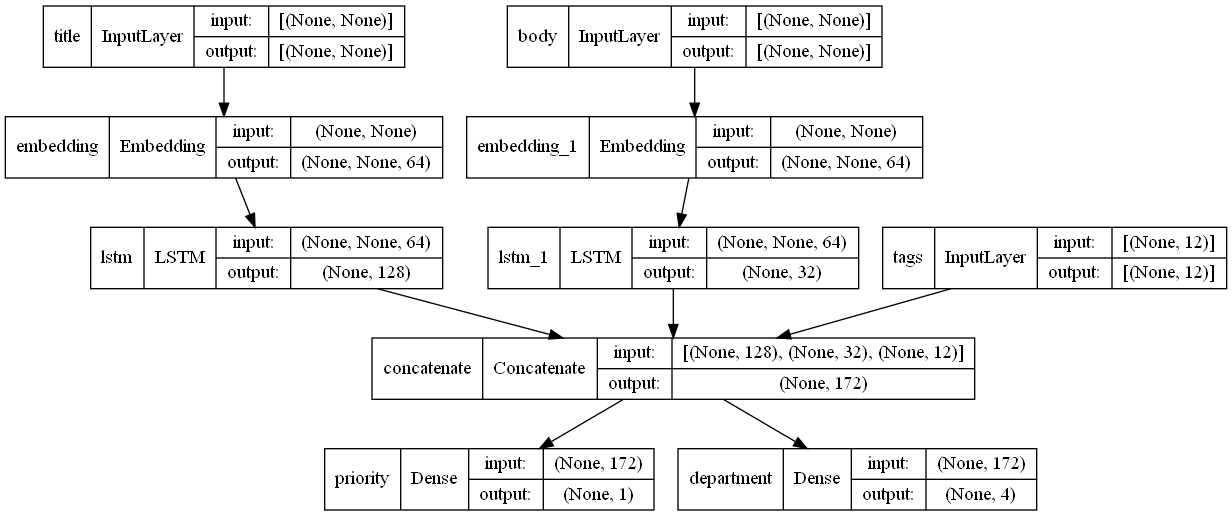

In [4]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

###### **When compiling this model, we can assign different losses to each output. We can also assign different weights to each loss- to modulate their contribution to the total training loss.**

In [11]:
model.compile(
        optimizer = keras.optimizers.RMSprop(1e-3),
        loss = [
                keras.losses.BinaryCrossentropy(from_logits=True),
                keras.losses.CategoricalCrossentropy(from_logits=True),
        ],
        loss_weights = [1.0, 0.2],
)

###### **Since the output layers have different names, we could also specify the losses and loss weights with the corresponding layer names:**

In [12]:
from time import clock_settime


clock_settime

###### **Train the model by passing lists of NumPy arrays of inputs and targets:**

In [13]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
        {"title": title_data, "body": body_data, "tags": tags_data},
        {"priority": priority_targets, "department": dept_targets},
        epochs = 2,
        batch_size = 32,
)

Epoch 1/2
40/40 [==============================] - 7s 53ms/step - loss: 1.2923 - priority_loss: 0.7022 - department_loss: 2.9503
Epoch 2/2
40/40 [==============================] - 2s 62ms/step - loss: 1.2772 - priority_loss: 0.6974 - department_loss: 2.8989: 2s - loss: 1.2845 - priority_loss


*When calling fit with a `Dataset` object, it should yield either a tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])` or a tuple of dictionaries like`({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.*

**A ResNet Model**
###### **In addition to models with multiple inputs and outputs, the functional API makes it easy to manipulate non-linear connectivity topologies -- there are models with layers that are not connected sequentially, which the `Sequential` API cannot handle.<br>A common use case for this is residual connections. Let's build a toy ResNet model for CIFAR10 dataset to demonstrate this:**

In [2]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 9, 9, 64)     0           ['conv2d_1[0][0]']               
                                                                                         

###### **Plot the model:**

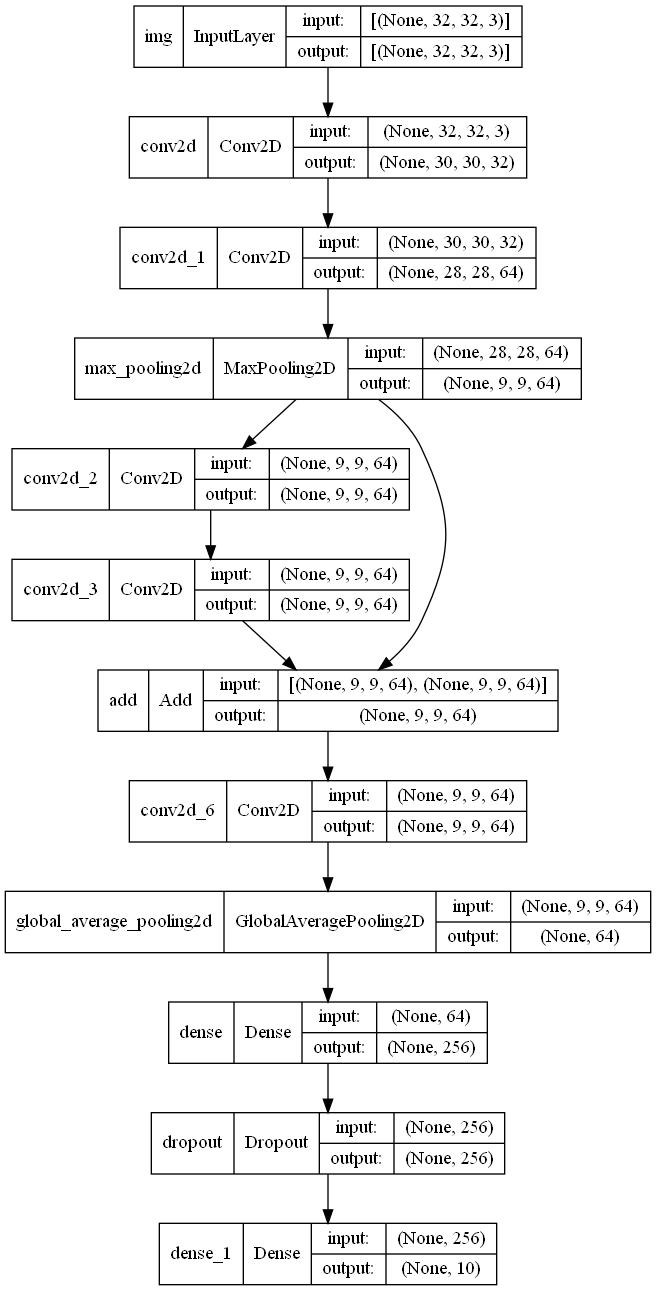

In [3]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

###### **Now, train the model:**

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer = keras.optimizers.RMSprop(1e-3),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"],
)
# We restrict the data to the first 10000 samples so as to limit execution time
model.fit(x_train[:10000], y_train[:10000], batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 33s 249ms/step - loss: 2.1007 - accuracy: 0.2033 - val_loss: 1.9614 - val_accuracy: 0.2590
Epoch 2/5
125/125 [==============================] - 31s 250ms/step - loss: 1.9539 - accuracy: 0.2451 - val_loss: 1.9561 - val_accuracy: 0.2445
Epoch 3/5
125/125 [==============================] - 31s 245ms/step - loss: 1.8435 - accuracy: 0.2875 - val_loss: 1.6912 - val_accuracy: 0.3525
Epoch 4/5
125/125 [==============================] - 32s 253ms/step - loss: 1.7568 - accuracy: 0.3363 - val_loss: 1.6376 - val_accuracy: 0.3890
Epoch 5/5
125/125 [==============================] - 31s 246ms/step - loss: 1.6712 - accuracy: 0.3590 - val_loss: 1.5823 - val_accuracy: 0.4195
